In [1]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path, PureWindowsPath

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.gpu_device_name()
print("New")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15072638381002503828
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18331196587265287924
physical_device_desc: "device: XLA_CPU device"
]
New


In [3]:
!pwd

/home/kumarbio/rai00016/Capstone/Code


In [4]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output


In [5]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [6]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(19, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(19, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(19, activation='softmax', name='output')(x)



In [7]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [8]:
epochs = 300
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [9]:
def data_generator(dataset, batch_size=64):
    print('Generating dataset')
    image_data_gen = ImageDataGenerator(rescale=1/255.0)
    image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                        batch_size=batch_size,
                                                        target_size=(224, 224),
                                                        shuffle=False)
    image_count = 0
    X_batches, Y_batches = [], []
    for X, Y in image_generator:
        X_batches.append(X)
        Y_batches.append(Y)
        image_count += X.shape[0]
    # Must interrupt image_generator
        if image_count >= image_generator.n:
            break
    X = np.concatenate(X_batches)
    Y = np.concatenate(Y_batches)
    return X, Y

In [10]:
class_names = os.listdir('/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/Train/')
target_dirs = {target: '/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/' + target for target in ['Train', 'Validation', 'Test']}

In [11]:

num_classes = 19
X, Y = dict(), dict()
for dataset in ['Test','Validation', 'Train']:
    # 
    X[dataset], Y[dataset] =  data_generator(dataset)

Generating dataset
Found 1330 images belonging to 19 classes.
Generating dataset
Found 1330 images belonging to 19 classes.
Generating dataset
Found 10640 images belonging to 19 classes.


In [12]:
!pwd

/home/kumarbio/rai00016/Capstone/Code


In [13]:
model_fit_history = model.fit(X['Train'], [Y['Train'],Y['Train'],Y['Train']], batch_size=64, epochs=100,
                              verbose=2, validation_data=(X['Validation'], [Y['Validation'],Y['Validation'],Y['Validation']]))

Train on 10640 samples, validate on 1330 samples
Epoch 1/100
 - 351s - loss: 4.7682 - output_loss: 2.9952 - auxilliary_output_1_loss: 2.9498 - auxilliary_output_2_loss: 2.9589 - output_accuracy: 0.0555 - auxilliary_output_1_accuracy: 0.0599 - auxilliary_output_2_accuracy: 0.0540 - val_loss: 4.5217 - val_output_loss: 2.7912 - val_auxilliary_output_1_loss: 2.8516 - val_auxilliary_output_2_loss: 2.9195 - val_output_accuracy: 0.1286 - val_auxilliary_output_1_accuracy: 0.1203 - val_auxilliary_output_2_accuracy: 0.0865
Epoch 2/100
 - 322s - loss: 4.3460 - output_loss: 2.7025 - auxilliary_output_1_loss: 2.7200 - auxilliary_output_2_loss: 2.7514 - output_accuracy: 0.1344 - auxilliary_output_1_accuracy: 0.1301 - auxilliary_output_2_accuracy: 0.1258 - val_loss: 4.2456 - val_output_loss: 2.6630 - val_auxilliary_output_1_loss: 2.6311 - val_auxilliary_output_2_loss: 2.6427 - val_output_accuracy: 0.1361 - val_auxilliary_output_1_accuracy: 0.1759 - val_auxilliary_output_2_accuracy: 0.1624
Epoch 3/100

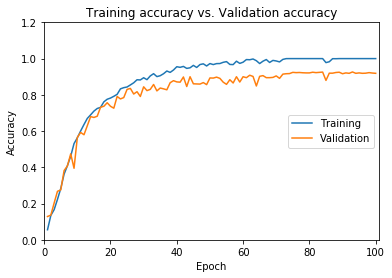

In [14]:
import matplotlib

epochs = len(model_fit_history.history['output_accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['output_accuracy'])
plt.plot(x, model_fit_history.history['val_output_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

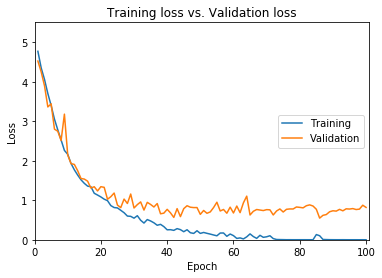

In [15]:

epochs = len(model_fit_history.history['loss'])
max_loss = max(max(model_fit_history.history['loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

In [16]:
predictions = model.predict(X['Test'])
y_pred = predictions[0]

y_pred_final = y_pred.argmax(axis = -1)

y_test = Y['Test']
ct = []
cp = []
acc = 0 
for i in range(y_test.shape[0]):
    class_true = np.where(y_test[i] == np.amax(y_test[i]))[0][0]
    ct.append(class_true)
    class_pred = y_pred_final[i]
    cp.append(class_pred)
    if class_true == class_pred:
        acc = acc + 1

accuracy = acc / y_test.shape[0]


In [17]:
print(accuracy)

0.937593984962406


In [18]:

print(accuracy_score(ct, cp))
print(classification_report(ct, cp))

0.937593984962406
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        70
           1       0.99      0.99      0.99        70
           2       0.95      0.99      0.97        70
           3       1.00      1.00      1.00        70
           4       0.89      0.90      0.89        70
           5       0.97      0.97      0.97        70
           6       0.85      0.89      0.87        70
           7       1.00      0.99      0.99        70
           8       0.99      0.97      0.98        70
           9       0.94      0.86      0.90        70
          10       0.83      0.84      0.84        70
          11       0.92      0.94      0.93        70
          12       0.93      0.91      0.92        70
          13       0.96      0.96      0.96        70
          14       0.97      0.96      0.96        70
          15       0.96      0.91      0.93        70
          16       0.88      0.96      0.92        70
         